<a href="https://colab.research.google.com/github/ivan-mihailov/LS-Unit-2-Sprint-3-Assignments/blob/main/DS_Sprint_Challenge_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
# YOUR CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import category_encoders as ce
import pdpbox

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [19]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)
# YOUR CODE HERE

# Transform 'Inspection Date' to DateTime format and set it as the index
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
df = df.set_index('Inspection Date')

df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


In [20]:
df.isna().sum()

Inspection ID                  0
DBA Name                       0
AKA Name                     623
License #                      5
Facility Type                224
Risk                          12
Address                        0
City                          53
State                         10
Zip                           26
Inspection Type                1
Violations                  9655
Latitude                     198
Longitude                    198
Location                     198
Fail                           0
Serious Violations Found    9655
dtype: int64

**Task 1 Test**

In [21]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [22]:
'''T2. Identify data leakage column.'''
leaky_col = ''
# YOUR CODE HERE
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [23]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [24]:
'''T3. Write wrangle function.'''
# YOUR CODE HERE
def wrangle(df):

  # Drop leaky column
  df = df.drop(leaky_col, axis = 1)

  # Drop high-cardinality columns
  high_card = ['DBA Name', 'AKA Name',	'Address',	'Violations',	'Location']
  df = df.drop(high_card, axis = 1)

  # Drop categorical columns that have only one category
  one_cat = 'State'
  df = df.drop(one_cat, axis = 1)

  # Drop numerical columns that are unique identifiers for each observation
  unique_ids = ['Inspection ID',	'License #']
  df = df.drop(unique_ids, axis = 1)
  
  return df

df = wrangle(df)

**Task 3 Test**

In [26]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [27]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
target = 'Fail' # Set up target column for analysis
X = df.drop(target, axis = 1) # Set up feature matrix by dropping the target column
y = df[target] # Set up target vector

**Task 4 Test**

In [28]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [29]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
cutoff = '2017-01-01' # Set up cutoff date between training and validation sets as Jan. 1, 2017

X_train = X[X.index < cutoff] # Set up training feature matrix by using index values smaller than the cutoff
y_train = y[y.index < cutoff] # Set up training target vector by using index values smaller than the cutoff
X_val = X[X.index >= cutoff] # Set up validation feature matrix by using index values larger than or equal to the cutoff
y_val = y[y.index >= cutoff] # Set up validation target vector by using index values larger than or equal to the cutoff

**Task 5 Testing**

In [30]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [31]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
from sklearn.metrics import accuracy_score
y_guess = y_train.mode() # Set up y_guess to equal the mode value for y_train
y_pred_base = [y_guess] * len(y_train) # Create y_pred vector where each value is equal to the y_guess (mode)
baseline_acc = accuracy_score(y_train, y_pred_base) # Calculate baseline accuracy score
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [32]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [259]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Create pipeline with 2 transformers (Ordinal Encoder and SimpleImputer) and
# RandomForest estimator (with default options because no better parameters were identified during hyperparameter tuning)

model_bag = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'most_frequent'),
    RandomForestClassifier()
)

model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [39]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [252]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
from xgboost import XGBClassifier

# Create pipeline with 2 transformers (Ordinal Encoder and SimpleImputer) and
# XGBClassifier estimator (with default options because no better parameters were identified during hyperparameter tuning)

model_boost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    XGBClassifier()
)

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [41]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [301]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.907858560260119
Validation accuracy: 0.6810387550797898

Boosting Model
Training accuracy: 0.7552059674373013
Validation accuracy: 0.704133214391912


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

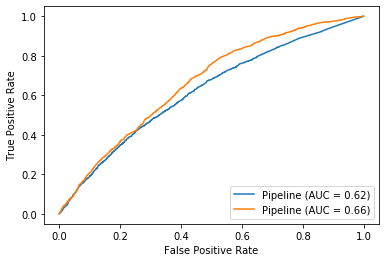

In [302]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
from sklearn.metrics import plot_roc_curve

# Plot ROC Curve (orange = model_boost, blue = model_bag)
classifiers = [model_bag, model_boost]
ax = plt.gca()

for i in classifiers:
    plot_roc_curve(i, X_val, y_val, ax=ax)


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [303]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
y_pred = model_bag.predict(X_val) # Calculate y_pred for the Bagging model
model_cr = classification_report(y_val, y_pred)
print(model_cr)

# Chose Bagging model over Boosting model because Bagging model had at least 
# some Recall on the Failed Inspections (unlike the Boost model which had 0.02 Recall)
# From a business perspective, if allocating limited inspector resources, I would use
# the Bagging model to assign inspectors because there is at least some chance to
# identify establishments that will Fail an inspection

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7092
           1       0.44      0.26      0.32      2997

    accuracy                           0.68     10089
   macro avg       0.59      0.56      0.56     10089
weighted avg       0.65      0.68      0.65     10089



**Task 10 Testing**

In [304]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [305]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
from sklearn.inspection import permutation_importance

pm = permutation_importance(model_bag, X_val, y_val) # Set up the permutation importances
feature_names = X_val.columns.to_list() # Assign the feature names to a list

# Create DataFrame using the feature names as an index and assigning the importances_mean and standard_deviation to the columns
permutation_importances = pd.DataFrame({'importances_mean' : pm['importances_mean'], 'importances_std' : pm['importances_std']}, index = feature_names)

**Task 11 Testing**

In [306]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f72ec896790>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f72ec77e190>})

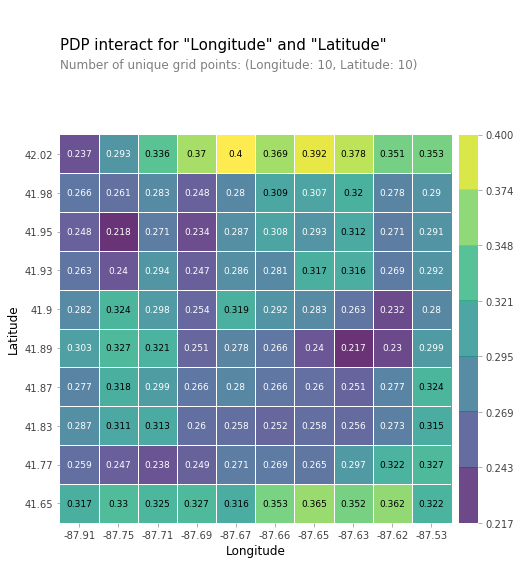

In [307]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
from pdpbox.pdp import pdp_interact_plot, pdp_interact

# Create a PDP interaction plot for Longitude and Latitude (with X_val having no NaNs)
interaction = pdp_interact(
    model = model_bag,
    dataset = X_val.dropna(),
    model_features = X_val.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)


What do you think? Is there a relationship between location and failing a food saftey inspection?

**Answer:** From the PDP Interaction Plot there does not appear to be significant relationship between location and failing a food safety inspection (given that the highest value appears to be 0.4 which is much less than the 1 that would signify a failed food inspection)